In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot, quarter_plot
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import pickle

## 1) Importing Data 

In [2]:
sp500=yf.download('^GSPC',start="2018-01-01", end="2022-12-31",interval='1d')

[*********************100%***********************]  1 of 1 completed


In [3]:
sp500.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,2683.729980,2695.889893,2682.360107,2695.810059,2695.810059,3397430000
2018-01-03,2697.850098,2714.370117,2697.770020,2713.060059,2713.060059,3544030000
2018-01-04,2719.310059,2729.290039,2719.070068,2723.989990,2723.989990,3697340000
2018-01-05,2731.330078,2743.449951,2727.919922,2743.149902,2743.149902,3239280000
2018-01-08,2742.669922,2748.510010,2737.600098,2747.709961,2747.709961,3246160000


In [4]:
sp500['Returns %']=sp500['Adj Close'].diff() / sp500['Adj Close']

In [5]:
sp500.head()

,Open,High,Low,Close,Adj Close,Volume,Returns %
Date,,,,,,,
2018-01-02,2683.729980,2695.889893,2682.360107,2695.810059,2695.810059,3397430000,NaN
2018-01-03,2697.850098,2714.370117,2697.770020,2713.060059,2713.060059,3544030000,0.006358
2018-01-04,2719.310059,2729.290039,2719.070068,2723.989990,2723.989990,3697340000,0.004012
2018-01-05,2731.330078,2743.449951,2727.919922,2743.149902,2743.149902,3239280000,0.006985
2018-01-08,2742.669922,2748.510010,2737.600098,2747.709961,2747.709961,3246160000,0.001660


<AxesSubplot:xlabel='Date'>

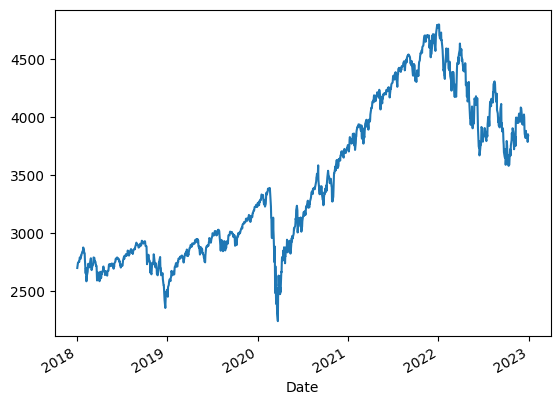

In [6]:
sp500['Adj Close'].plot()

<AxesSubplot:xlabel='Date'>

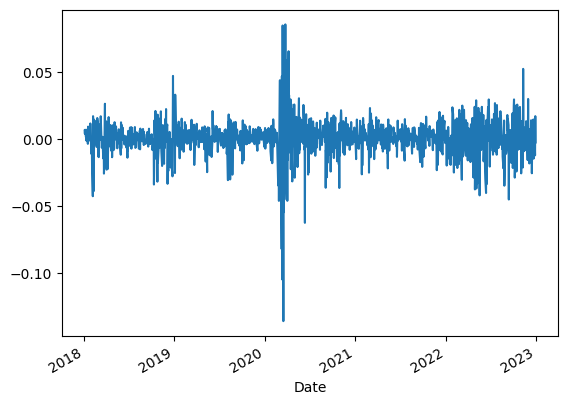

In [7]:
sp500['Returns %'].plot()

In [8]:
# sp500['Adj Close'].ewm(span=100).mean().plot()

In [9]:
# sp500['Adj Close']=sp500['Adj Close'].ewm(span=80).mean()

<AxesSubplot:xlabel='Date'>

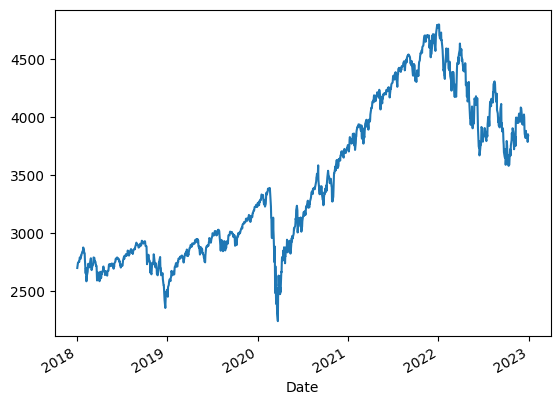

In [10]:
sp500['Adj Close'].plot()

The cyclical component represents phenomena that happen across seasonal periods. Cyclical patterns do not have a fixed period like seasonal patterns do. An example of a cyclical pattern is the cycles of boom and bust that stock markets experience in response to world events. <br>
This data seems to have cyclical component with no consistent cyclicity. So instead of decomposing it into trend, seasonality, noise, we would just keep it as it is.

In [11]:
sp500['Adj Close'].shape

(1259,)

Figure(640x480)


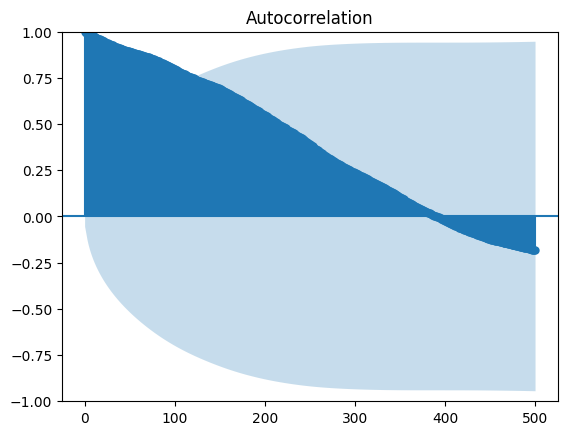

In [12]:
print(plot_acf(sp500['Adj Close'],lags=500))

Also autocorrelation graph shows no seasonal pattern.

## 2) Decomposition of Data 

In [35]:
sp500_decomposition = seasonal_decompose(x=sp500['Adj Close'], model='additive', period=50)

### 2.1) Trend 

<AxesSubplot:xlabel='Date'>

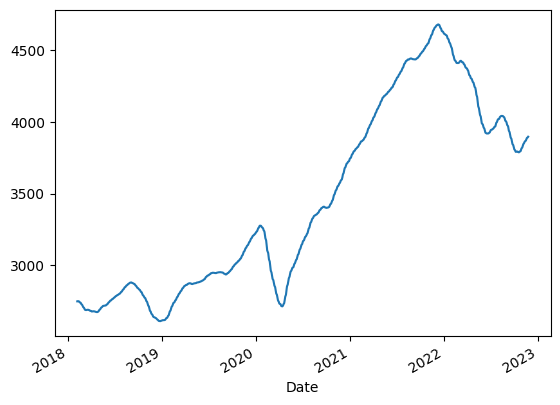

In [36]:
sp500_decomposition.trend.plot()

### 2.2) Seasonal 

<AxesSubplot:xlabel='Date'>

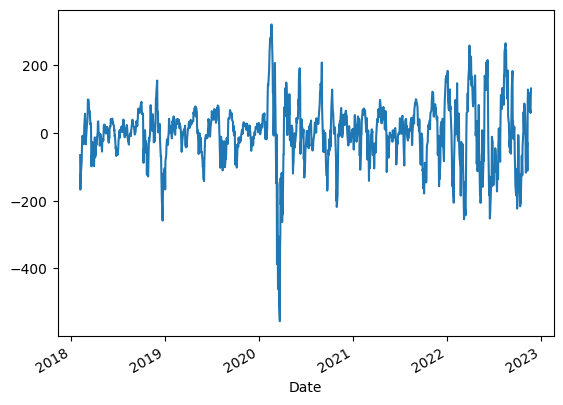

In [37]:
(sp500_decomposition.seasonal+sp500_decomposition.resid).plot()

<AxesSubplot:xlabel='Date'>

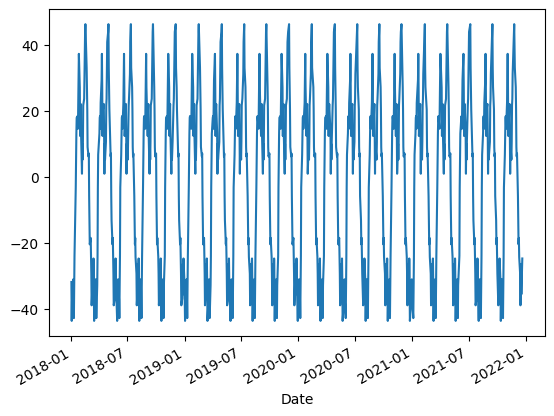

In [38]:
sp500_decomposition.seasonal[:1000].plot()

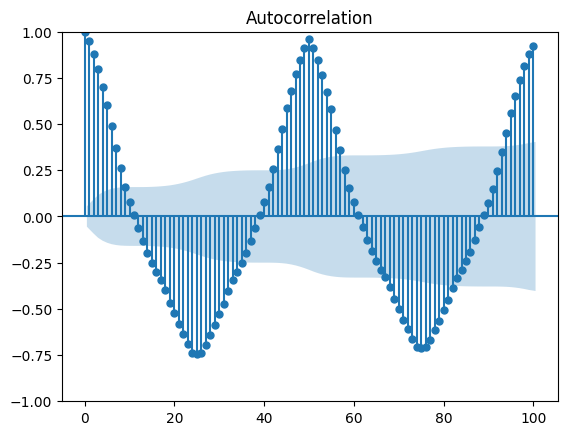

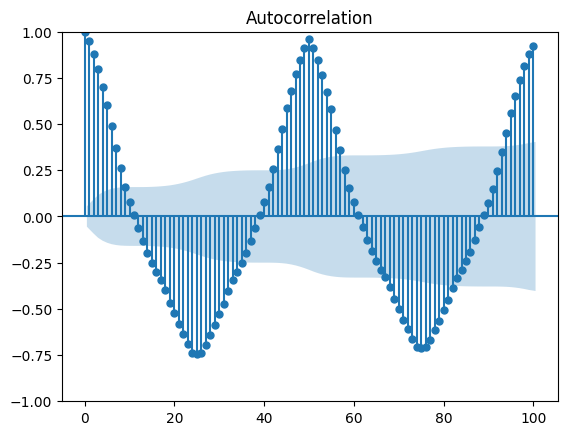

In [39]:
plot_acf(sp500_decomposition.seasonal,lags=100)

### 2.3) Residual 

<AxesSubplot:xlabel='Date'>

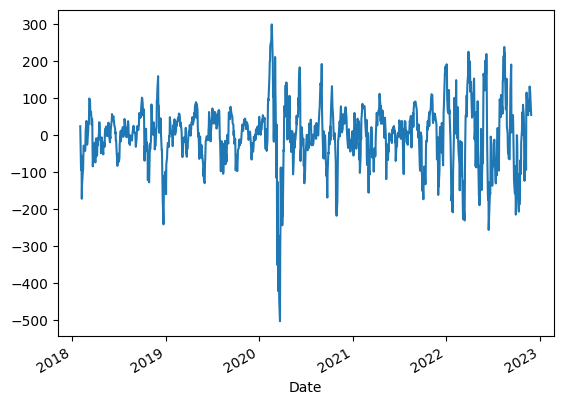

In [18]:
sp500_decomposition.resid.dropna().plot()

## 3) Stationarity Test

<AxesSubplot:xlabel='Date'>

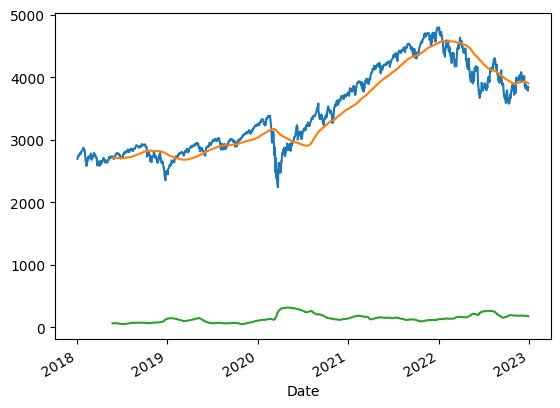

In [19]:
sp500['Adj Close'].plot()
sp500['Adj Close'].rolling(100).mean().plot()
sp500['Adj Close'].rolling(100).std().plot()

### 3.1) Constant Mean Test

In [20]:
# difference between max and min mean
( sp500['Adj Close'].rolling(500).mean().max() - sp500['Adj Close'].rolling(500).mean().min() ) * 100 / sp500['Adj Close'].rolling(500).mean().max()
# The mean appears to be constant considering the value of mean, since the difference between minimum and max is about 17% from it's max value

32.49888830235192

In [21]:
# chunks = np.split(monthly_temp.temp, indices_or_sections=12)

### 3.2) Constant Std Test

In [22]:
# difference between max and min mean
( sp500['Adj Close'].rolling(500).std().max() - sp500['Adj Close'].rolling(500).std().min() ) * 100 / sp500['Adj Close'].rolling(500).std().max()
# the standard deviation is not constant

76.11863256531076

### 3.3) Dickey Fuller Test 

In [23]:
adf_sp500, pvalue_sp500, usedlag_, nobs_, critical_values_sp500, icbest_ = adfuller(sp500['Adj Close'])
pvalue_sp500

0.6579935484513542

The pvalue of dickey fuller should be below 0.05. <br>
The next dickey fuller test would be conducted on a data after removing autocorrelation with differencing. 

In [24]:
sp500_diff=sp500['Adj Close'].diff(periods=1)[~np.isnan(sp500['Adj Close'].diff(periods=1))]
adf_sp500_diff, pvalue_sp500_diff, usedlag_diff, nobs_diff, critical_values_sp500, icbest_diff = adfuller(sp500_diff)
pvalue_sp500_diff

5.35705593440931e-20

In [25]:
sp500_log_diff=np.log(sp500.loc[~np.isnan(np.array(sp500['Returns %'])),'Returns %']+1)
adf_sp500_log_diff, pvalue_sp500_log_diff, usedlag_log_diff, nobs_log_diff, critical_values_sp500, icbest_log_diff = adfuller(sp500_diff)
pvalue_sp500_log_diff

5.35705593440931e-20

The value is lower than 0.05 so, the stationary test is passed.

<AxesSubplot:xlabel='Date'>

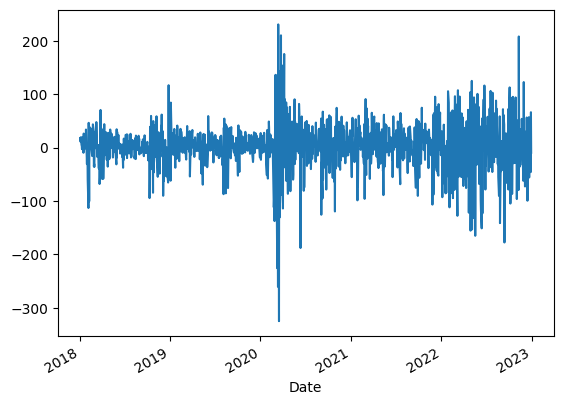

In [26]:
sp500_diff.plot()

### 3.4) Autocorrelation Tests 

Figure(640x480)
Figure(640x480)


C:\Users\hp\miniconda3\envs\kirtesh\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


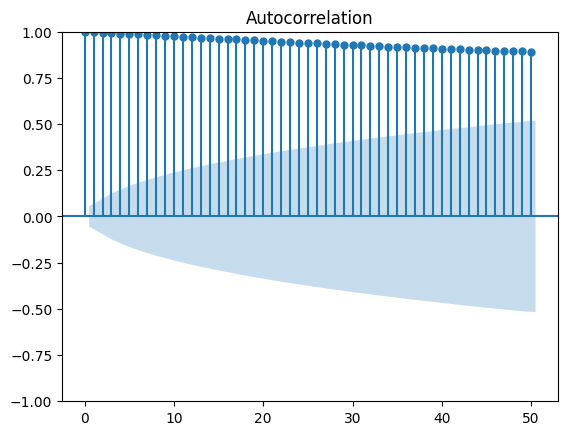

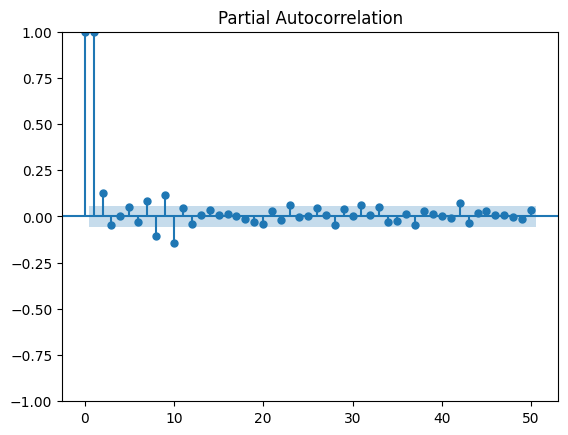

In [27]:
print(plot_acf(sp500['Adj Close'],lags=50))
print(plot_pacf(sp500['Adj Close'],lags=50))

In [28]:
# log difference data

Figure(640x480)
Figure(640x480)


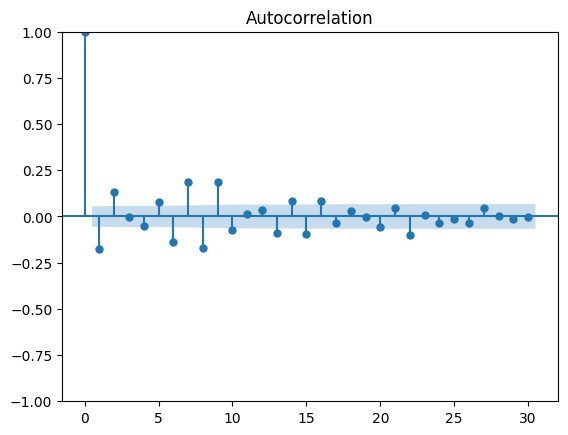

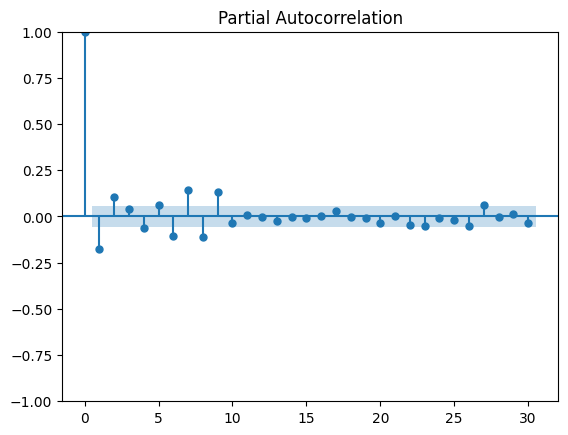

In [29]:
print(plot_acf(np.log(sp500.loc[~np.isnan(np.array(sp500['Returns %'])),'Returns %']+1),lags=30))
print(plot_pacf(np.log(sp500.loc[~np.isnan(np.array(sp500['Returns %'])),'Returns %']+1),lags=30))